# Demo: Part 1

This notebook is part 1 of a 3-part demonstration of the model, tested on a Windows 11 machine.

### Instructions:
1. **Setup**: Follow the instructions in [README.md](README.md) (also given [below](#setup-details)) to:
   - Set up the required [Conda environments](README.md#setup).
   - Download all necessary [data and models](README.md#download-models-and-data).
   - Prepare codebase of the [submodule](README.md#prepare-codebase)  

2. **Environment**: Use the `retrosub` conda virtual environment for this notebook. Refer to the [README.md](README.md) file for detailed instructions on setting up the required environments.  

3. **Next Step**: After completing this notebook, proceed to [./RetrievalModel/demo_part2.ipynb](RetrievalModel/demo_part2.ipynb).  

### Setup Details

1. **Setup Conda environments**

- clone repo. If you are in windows, best if you clone in the system drive (C:)

        git clone https://github.com/MDFahimAnjum/RetroSub_Research


- fix typo, and change some codes to run the submodules with recent pytorch version. In windows, open git bash and run following. If you try the following in cmd or powershell, you will get errors due to path notations

        bash scripts/step0_fix_submodule.sh 

- conda environment for reaction retrieval. In windows, open anaconda prompt in the root directory

        conda create -n retrieval python=3.6
        conda activate retrieval
        #conda run -n retrieval pip install -r RetrievalModel/requirements.txt -f https://download.pytorch.org/whl/torch_stable.html
        pip install torch sacrebleu transformers==2.11.0 jsonlines regex scikit-learn scipy
        conda install -c pytorch faiss-cpu

- conda environment for substructure extraction, seq2seq model inference, ranking model training. for windows, open anaconda prompt and cd to the root folder

        conda create -n retrosub python=3.7 -y
        conda activate retrosub
        conda install -c pytorch pytorch torchvision -y #Alternatively: pip install torch torchvision
        pip install rdkit-pypi tqdm func-timeout future six pandas gputil notebook
        cd MolecularTransformer
        conda run -n retrosub pip install torchtext==0.3.1 
        conda run -n retrosub pip install -e .

- conda environment for model training (requires python 3.5)

        cd MolecularTransformer
        conda create -n mol_transformer python=3.5 -y
        conda activate mol_transformer
        conda install -c pytorch pytorch torchvision -y
        pip install future six tqdm pandas
        conda run -n mol_transformer pip install torchtext==0.3.1
        conda run -n mol_transformer pip install -e . 


2. **Download models and data** 
- Download processed data, models and results [here](https://figshare.com/ndownloader/files/41144306).
- Extract in root folder

3. **Prepare Codebase**

- Change code of submodule (reaction retrieval) to run on CPU in the code folder.

        bash scripts/step0_fix_demo.sh 

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import operator
import pickle
import random
from collections import Counter

from rdkit import Chem
from rdkit.Chem import Draw

from demo import (extract_all, load_retrieved_candidates,
                  load_sub_seq2seq_output, merge,
                  merge_predicted_frag_with_substructures,
                  prepaire_sub_seq2seq_input, rerank_candidates,
                  save_input_for_dual_encoder, save_input_for_subseq2seq,
                  view_sub_extractions)
from utils.smiles_utils import canonicalize_smiles, smi_tokenizer


In [4]:
# this file is a dictionary, key: target (reactants), value: source (all possible products)
# it is generated on the train and val data by 'data_utils/collect_reaction.py', and is used
# to filter substructures extracted from candidate reactants (target side) but not exists in
# the product molecules (source side). It means that the substructures shall also remain
# unchanged during the reaction from source (product of retrieved candidate reactants) to 
# target (retrieved candidate reactants). 
# load only for the first time
try:
    all_reaction_t2s
except NameError:
    all_reaction_t2s = pickle.load(open('data/uspto_full/reaction.pkl', 'rb'))

input_product_smiles: COC(=O)Cc1cc2ccc(F)cc2c(-c2ccc(S(C)(=O)=O)cn2)c1C
golden_reactants_smiles: COC(=O)Cc1cc2ccc(F)cc2c(B2OC(C)(C)C(C)(C)O2)c1C.CS(=O)(=O)c1ccc(Br)nc1


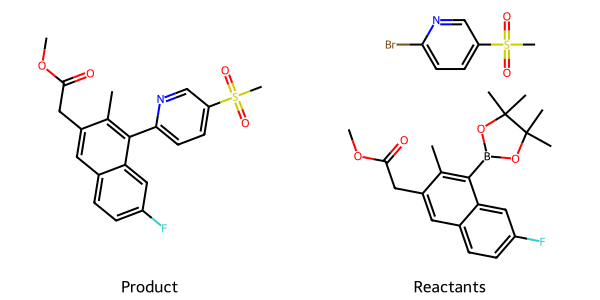

In [5]:

# we prepaire 200 samples in demo_data/test_cases.json, in which 's' is the source (product) and 't' is the target (reactant)
test_cases = json.load(open('demo_data/test_cases.json'))
# some typical cases in test_cases.json, change the value of test_case_idx below to view results
#   1 Suzuki-Miyaura Cross Coupling
#   2 Amide Condensation
#   5 SN2 Substitution
#   6 Ester Hydrolysis(Deprotection)
#  16 Sonogashira Cross Coupling
#  19 Nitro Reduction
#  22 Free Radical Halogenation
#  43 Nitrile Hydrolysis
#  56 Aldol Condensation
# 145 Sulphur Oxidation

# please change test_case_idx, or change the input below, to try other examples
test_case_idx = 1 # Suzuki-Miyaura Cross Coupling

input_product_smiles, golden_reactants_smiles = test_cases[test_case_idx]['s'], test_cases[test_case_idx]['t']

# the dual encoder was trained on canonicalized SMILES
input_product_smiles = canonicalize_smiles(input_product_smiles)
golden_reactants_smiles = canonicalize_smiles(golden_reactants_smiles)
print(f'input_product_smiles: {input_product_smiles}')
print(f'golden_reactants_smiles: {golden_reactants_smiles}')
Draw.MolsToGridImage([Chem.MolFromSmiles(input_product_smiles), Chem.MolFromSmiles(golden_reactants_smiles)], \
    legends=['Product', 'Reactants'],
    molsPerRow=2, subImgSize=(300, 300))

In [6]:
# the input of the dual encoder is tokenized SMILES of product
tokenized_product_smi = smi_tokenizer(input_product_smiles)
# save the input to file
save_input_for_dual_encoder(tokenized_product_smi)
print('tokenized_product_smi: ', tokenized_product_smi)

tokenized_product_smi:  C O C ( = O ) C c 1 c c 2 c c c ( F ) c c 2 c ( - c 2 c c c ( S ( C ) ( = O ) = O ) c n 2 ) c 1 C
